In [11]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from scipy.ndimage import generic_filter, gaussian_filter, median_filter
from skimage.morphology import erosion, disk
import marker_detection

%matplotlib inline
# Étend la taille des figures
plt.rcParams["figure.figsize"] = (12, 7)

In [1]:
image = cv2.imread(r'C:\Users\LEA\Desktop\Poly\H2023\Projet3\Data\Ete_2022\Participant05\autocorrection\Prise01\intensity\auto_01_010457_I_0.jpg')
crop = (350, 1500, 200, 1000)

image = marker_detection.preprocess(image, crop)[0]

plt.imshow(image, cmap='gray')
plt.show()

NameError: name 'cv2' is not defined

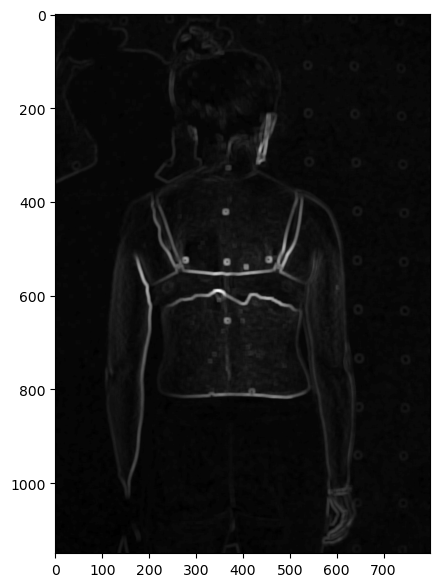

In [102]:
w = image.shape[0]
h = image.shape[1]
im_std = generic_filter(image, np.std, 9, mode='nearest').reshape(w,h)
plt.imshow(im_std, cmap='gray')
plt.show()

4.0141989130434785 80
81
522 433


C:\Users\LEA\AppData\Local\Temp\ipykernel_14116\3271735743.py:17: UserWarning: Attempting to set identical bottom == top == -0.5 results in singular transformations; automatically expanding.
  ax3.imshow(image2, cmap='gray')


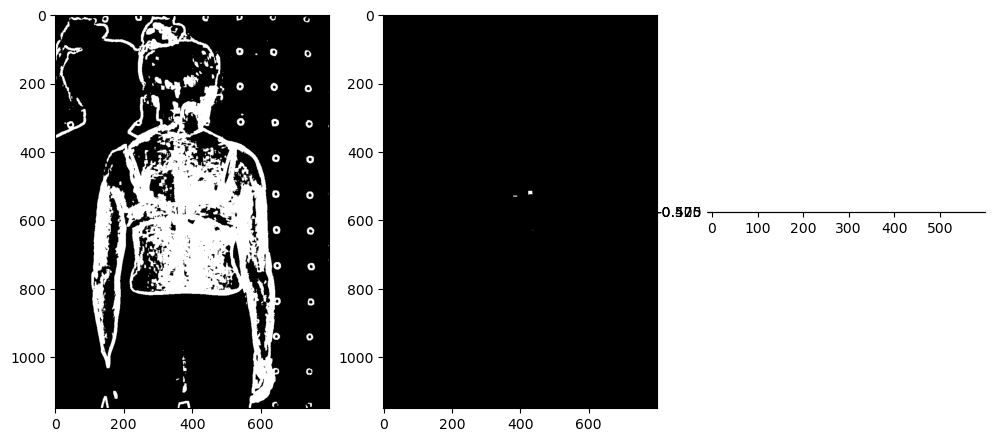

In [103]:
mean = im_std.mean()
max = im_std.max()
print(mean, max)
im_crop = np.where(im_std > mean, 1, 0)
im_crop_g = gaussian_filter(im_crop, 7)
crop = np.where(im_crop_g == 1)
mid = int(len(crop[0])/2)
print(mid)
crop_y = crop[0][mid]
crop_x = crop[1][mid]
print(crop_y, crop_x)

image2 = image[crop_y-800:crop_y+80, crop_x-350:crop_x+250]
fig, (ax1, ax2, ax3) = plt.subplots(1,3)
ax1.imshow(im_crop, cmap='gray')
ax2.imshow(im_crop_g, cmap='gray')
ax3.imshow(image2, cmap='gray')
plt.show()

(1935, 1176, 3)
0 255 32.79165348309866


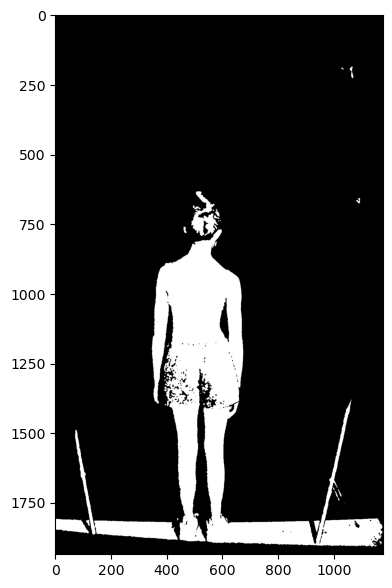

In [25]:
z_nobg = cv2.imread(r'D:\StageE23\Data\Ete_2022\Participant01\BD\Contraint\Prise01\xyz_nobg\BD_contraint_01_005390_XYZ_0.png')
print(z_nobg.shape)
print(np.min(z_nobg), np.max(z_nobg), np.mean(z_nobg))

plt.imshow(z_nobg)
plt.show()

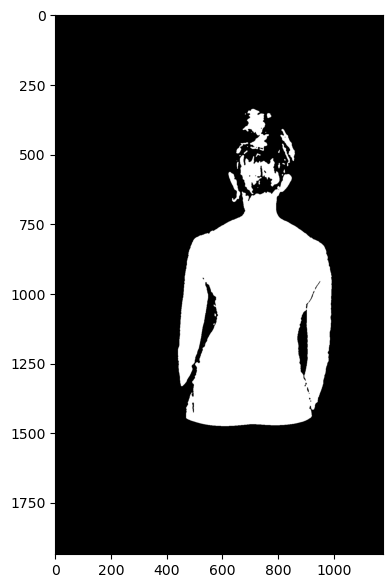

[[ 337  707]
 [ 337  708]
 [ 337  709]
 ...
 [1475  621]
 [1475  622]
 [1475  623]]


In [20]:
z_nobg = median_filter(z_nobg, 5)
plt.imshow(z_nobg)
plt.show()

body = np.argwhere(z_nobg[:1500,:,0] > 100)
print(body)

[337 707] [1199  441] [983 991]


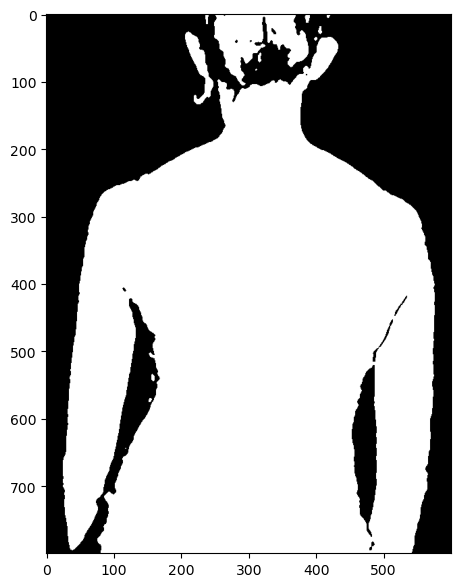

In [18]:
top = body[0]
body_sorted = sorted(body, key=lambda list: list[1])
left = body_sorted[0]
right = body_sorted[-1]
print(top, left, right)

w1 = left[1]-25
w2 = right[1]+25
h1 = top[0]+200
h2 = top[0]+1000

im_crop = z_nobg[h1:h2, w1:w2, :]
plt.imshow(im_crop)
plt.show()

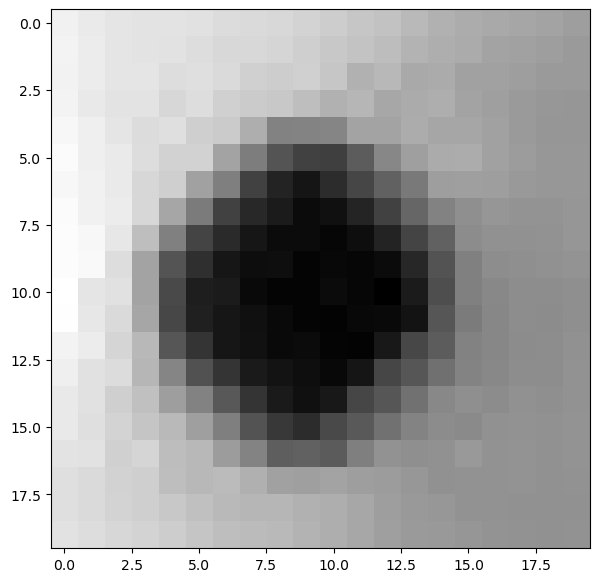

In [18]:
image = cv2.imread('D:\StageE23\Data\Ete_2022\Participant05\BD\Libre\Prise01/Preprocessed/BD_Libre_01_001665_I_0.jpg')
image_bw = cv2.cvtColor(image[270:290, 200:220], cv2.COLOR_BGR2GRAY).astype(np.uint8)
plt.imshow(image_bw, cmap='gray')
plt.show()

In [30]:
coordo = {"T1": [281.4342956542969, 118.31011962890625], "T2": [285.3641933287951, 212.79782164737918], "L": [281.432861328125, 352.0157470703125]}
a = np.sqrt((coordo['T1'][0]-coordo['T2'][0])**2+(coordo['T1'][1]-coordo['T2'][1])**2)
b = np.sqrt((coordo['T2'][0]-coordo['L'][0])**2+(coordo['T2'][1]-coordo['L'][1])**2)
c = np.sqrt((coordo['T1'][0]-coordo['T2'][0])**2+(coordo['T1'][1]-coordo['T2'][1])**2)
scoliosis_angle = 180-np.degrees(np.arccos((c**2+b**2-a**2)/(2*a*b)))
print(scoliosis_angle)

137.4218955929418


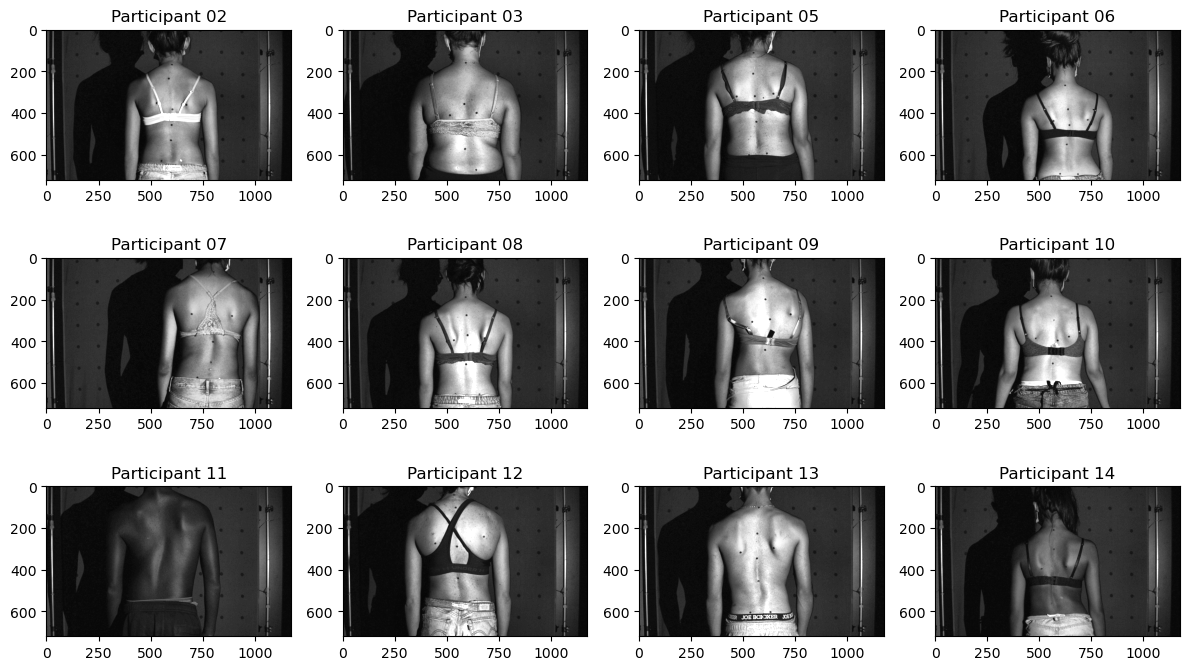

In [33]:
crop = (0, 1176, 560, 1280)
fig, ([ax2, ax3, ax5, ax6], [ax7, ax8, ax9, ax10], [ax11, ax12, ax13, ax14]) = plt.subplots(3,4)

axs = (ax2, ax3, ax5, ax6, ax7, ax8, ax9, ax10, ax11, ax12, ax13, ax14)
pt = ['02','03','05','06','07','08','09','10','11','12','13','14']

for i in range(len(pt)):
    path = r'D:\StageE23\Data\Ete_2022\Participant' + pt[i] + r'\autocorrection\Prise02\intensity'
    im = cv2.imread(os.path.join(path, os.listdir(path)[0]))
    image = marker_detection.preprocess(im, crop)[0]
    axs[i].imshow(image, cmap='gray', vmin=0, vmax=180)
    axs[i].set_title(f'Participant {pt[i]}')
plt.tight_layout()
plt.show()